#<font color='blue'>**TECH CHALLENGE FASE 4 - MACHINE LEARNING AND TIME SERIES:**
**PREVENDO O PREÇO DO PETRÓLEO BRENT**</font>
-------

#<font color='green'> **BUSCANDO DADOS**</font>
----------


In [1]:
import requests
import time
import pandas as pd

# URL e parâmetros da API
url = "https://api.eia.gov/v2/petroleum/pri/spt/data/?frequency=daily&data[0]=value&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
api_key = "tVxuHF9kzFCubhur9GqPqoe0zHiLixAhf1pHpz87"

# Inicializar lista para armazenar os dados
todos_os_dados = []

# Definir o tamanho da página de dados (pode ser um valor como 5000 ou outro permitido pela API)
length = 5000  # Tamanho máximo de registros por requisição

# Loop para obter todas as páginas de dados
offset = 0
while True:
    params = {
        "api_key": api_key,
        "offset": offset,  # Indica o ponto inicial para a próxima página
        "length": length,  # Número de registros por requisição
    }

    # Fazer a requisição
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"Erro: {response.status_code} - {response.text}")
        break

    # Obter os dados da resposta
    dados = response.json().get('response', {}).get('data', [])

    if not dados:  # Se não houver mais dados, sair do loop
        break

    # Adicionar os dados à lista
    todos_os_dados.extend(dados)

    # Atualizar o offset para a próxima página
    offset += length

    # Evitar sobrecarregar o servidor
    time.sleep(1)  # Espera de 1 segundo entre requisições

# Criar um DataFrame com todos os dados
df = pd.DataFrame(todos_os_dados)
print(f"Total de registros obtidos: {len(df)}")


Total de registros obtidos: 87156


In [2]:
df_filtrado = df[df['series'] == 'RBRTE']

In [3]:
df_filtrado.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
2,2024-11-25,ZEU,NA,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE,Europe Brent Spot Price FOB (Dollars per Barrel),74.27,$/BBL
12,2024-11-22,ZEU,NA,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE,Europe Brent Spot Price FOB (Dollars per Barrel),76.1,$/BBL
23,2024-11-21,ZEU,NA,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE,Europe Brent Spot Price FOB (Dollars per Barrel),75.09,$/BBL
43,2024-11-20,ZEU,NA,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE,Europe Brent Spot Price FOB (Dollars per Barrel),74.33,$/BBL
46,2024-11-19,ZEU,NA,EPCBRENT,UK Brent Crude Oil,PF4,Spot Price FOB,RBRTE,Europe Brent Spot Price FOB (Dollars per Barrel),74.32,$/BBL


In [4]:
df_filtrado = df_filtrado[['period', 'value']]

In [5]:
df_filtrado.head()

,period,value
2,2024-11-25,74.27
12,2024-11-22,76.1
23,2024-11-21,75.09
43,2024-11-20,74.33
46,2024-11-19,74.32


In [6]:
#Renomeando colunas
novas_colunas = {'period' : 'data',
                 'value' : 'preco'}
df_filtrado = df_filtrado.rename(columns = novas_colunas)

In [7]:
#Mudando o tipo da coluna de data para datetime
import datetime as datetime
# The original format was '%Y-/%m/-%d', which is incorrect.
# It should be '%Y-%m-%d' to match the format "2024-11-25".
df_filtrado['data'] = pd.to_datetime(df_filtrado['data'], format='%Y-%m-%d')
df_filtrado['preco'] = pd.to_numeric(df_filtrado['preco'], errors='coerce').astype(float)

In [8]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9522 entries, 2 to 86080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    9522 non-null   datetime64[ns]
 1   preco   9522 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 481.2 KB


In [9]:
#Identificando quantidade de valores vazios por coluna
df_filtrado.isnull().sum()

,0
data,0
preco,0


#<font color='green'> **ANÁLISE EXPLORATÓRIA DOS DADOS(EDA)**</font>
----------

In [10]:
#Analisando tamanho do dataset
df_filtrado.shape

(9522, 2)

In [11]:
#Organizando o dataframe pela data de forma decrescente
df_filtrado = df_filtrado.sort_values(by='data', ascending=False)
df_filtrado.head()

,data,preco
2,2024-11-25,74.27
12,2024-11-22,76.10
23,2024-11-21,75.09
43,2024-11-20,74.33
46,2024-11-19,74.32


In [12]:
#Estatísticas descritivas do df
df_filtrado['preco'].describe().round(2)

,preco
count,9522.00
mean,50.20
std,32.87
min,9.10
25%,19.35
50%,43.24
75%,74.58
max,143.95


# <font color='green'>**VISUALIZAÇÕES INICIAIS**</font>
-------------

In [13]:
#Importando as bibliotecas de visualização
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

In [14]:
#Criando uma cópia do df original para adicionar colunas de suporte para visualizações iniciais
df_filtrado_viz = df_filtrado.copy()
df_filtrado_viz.head()

,data,preco
2,2024-11-25,74.27
12,2024-11-22,76.10
23,2024-11-21,75.09
43,2024-11-20,74.33
46,2024-11-19,74.32


In [15]:
#Criando coluna de mes e ano
df_filtrado_viz['MES_ANO'] = pd.to_datetime(df_filtrado_viz['data']).dt.to_period('M')
df_filtrado_viz['ANO'] = pd.to_datetime(df_filtrado_viz['data']).dt.to_period('Y')

In [16]:
#Convertendo coluna de mes e ano para Timestamp
df_filtrado_viz['MES_ANO'] = df_filtrado_viz['MES_ANO'].dt.to_timestamp()
df_filtrado_viz['ANO'] = df_filtrado_viz['ANO'].dt.to_timestamp()
df_filtrado_viz.head()

,data,preco,MES_ANO,ANO
2,2024-11-25,74.27,2024-11-01,2024-01-01
12,2024-11-22,76.10,2024-11-01,2024-01-01
23,2024-11-21,75.09,2024-11-01,2024-01-01
43,2024-11-20,74.33,2024-11-01,2024-01-01
46,2024-11-19,74.32,2024-11-01,2024-01-01


In [17]:
#Visualizando a quantidade de anos
pd.Series(df_filtrado_viz['ANO'].unique()).sort_values()

,0
37,1987-01-01
36,1988-01-01
35,1989-01-01
34,1990-01-01
33,1991-01-01
32,1992-01-01
31,1993-01-01
30,1994-01-01
29,1995-01-01
28,1996-01-01


In [18]:
df_filtrado_viz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9522 entries, 2 to 86080
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     9522 non-null   datetime64[ns]
 1   preco    9522 non-null   float64       
 2   MES_ANO  9522 non-null   datetime64[ns]
 3   ANO      9522 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1)
memory usage: 630.0 KB


-------
Análise de correlação de Pearson



- ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;
- ρ = 0,7 a 0,9 (positivo ou negativo): correlação forte;
- ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;
- ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;
- ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.
------

<Axes: >

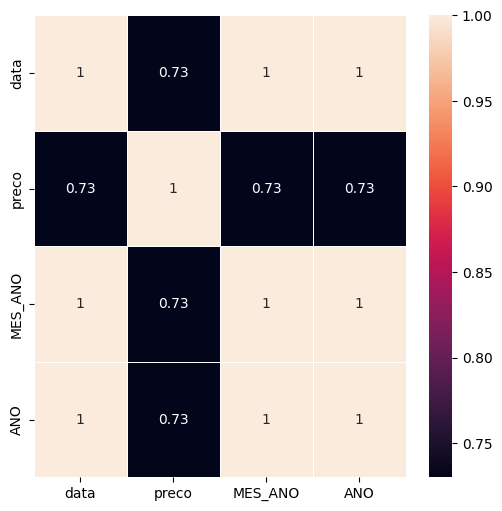

In [19]:
correlation_matrix = df_filtrado_viz.corr().round(2)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

In [20]:
#Visualizando os valores min, max e media do preco do petroleo por agrupamento
df_ano_valor = df_filtrado_viz[['ANO', 'preco']]
df_ano_valor = df_ano_valor.groupby(['ANO']).agg(['min', 'max', 'mean']).round(2)
df_ano_valor.head()

preco              
              min    max   mean
ANO                            
1987-01-01  15.03  20.95  18.53
1988-01-01  11.20  17.95  14.91
1989-01-01  16.05  22.25  18.23
1990-01-01  14.68  41.45  23.76
1991-01-01  17.60  30.28  20.05

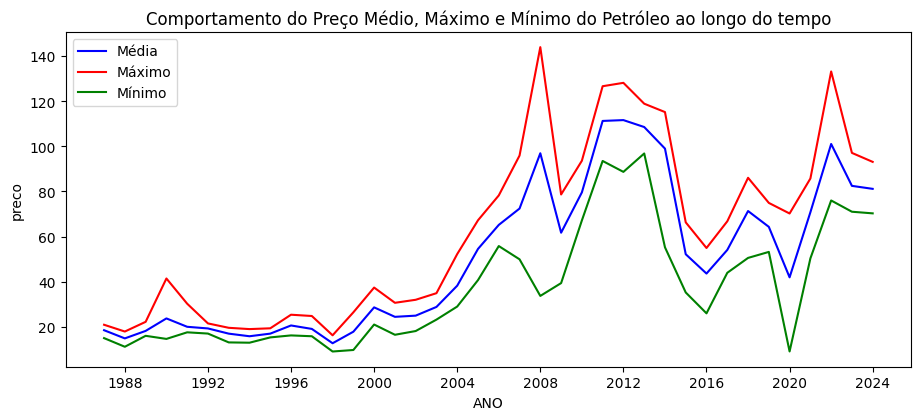

In [21]:
#Plot de gráfico de linhas para acompanhar a evolução do fechamento ao longo do tempo

plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1)
sns.lineplot(x=df_ano_valor.index, y=df_ano_valor['preco']['mean'], data=df_ano_valor, color='blue', errorbar=None)
plt.xlabel('ANO')
plt.ylabel('preco')
plt.title('Comportamento do Preço Médio do Petróleo ao longo do tempo')

plt.subplot(4, 2, 1)
sns.lineplot(x=df_ano_valor.index, y=df_ano_valor['preco']['max'], data=df_ano_valor, color='red', errorbar=None)
plt.xlabel('ANO')
plt.ylabel('preco')
plt.title('Comportamento do Preço Mínimo do Petróleo ao longo do tempo')

plt.subplot(4, 2, 1)
sns.lineplot(x=df_ano_valor.index, y=df_ano_valor['preco']['min'], data=df_ano_valor, color='green', errorbar=None)
plt.xlabel('ANO')
plt.ylabel('preco')
plt.title('Comportamento do Preço Médio, Máximo e Mínimo do Petróleo ao longo do tempo')

plt.legend(['Média', 'Máximo', 'Mínimo'])
plt.show()

Text(0.5, 1.0, 'Comportamento do Preço do Petróleo ao Longo dos Meses/Anos')

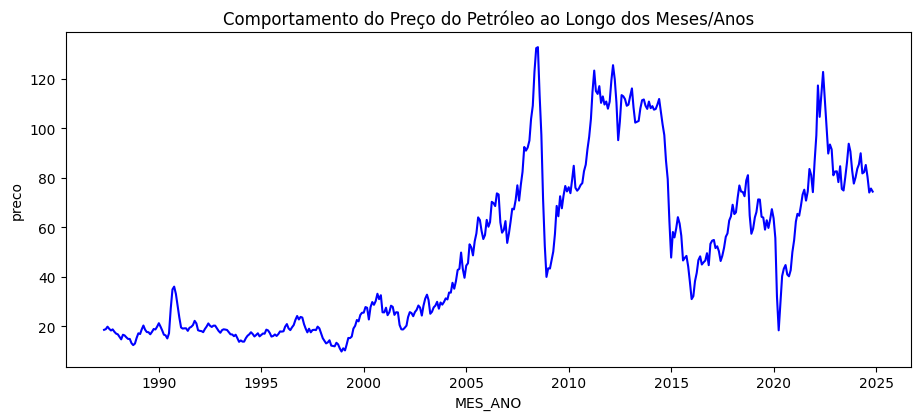

In [22]:
#Visualizando o comportamento do preco do petroleo ao longo dos meses/anos
plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1)
sns.lineplot(x=df_filtrado_viz['MES_ANO'], y=df_filtrado_viz['preco'], data=df_filtrado_viz, color='blue', errorbar=None)
plt.xlabel('MES_ANO')
plt.ylabel('preco')
plt.title('Comportamento do Preço do Petróleo ao Longo dos Meses/Anos')

<Figure size 2400x2000 with 0 Axes>

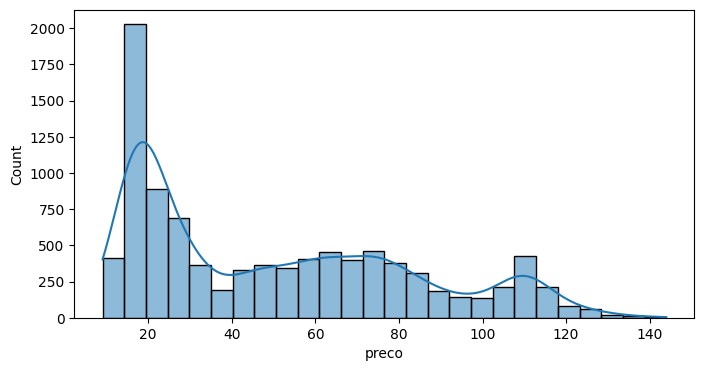

In [23]:
#Gráfico de historiograma

plt.figure(figsize=(24,20))

fig, axes = plt.subplots(figsize=(8,4))
sns.histplot(data=df_filtrado_viz, x="preco", kde=True)
plt.show()

#<font color='green'>**CRIAÇÃO E CONCLUSÃO DOS MODELOS**</font>
--------------

###<font color='red'>**SELECIONANDO O DATAFRAME**</font>

In [24]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9522 entries, 2 to 86080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    9522 non-null   datetime64[ns]
 1   preco   9522 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 481.2 KB


In [25]:
#Organizando o dataframe
df_filtrado.sort_values(by='data', ascending=True, inplace=True)
df_filtrado.head()

,data,preco
86080,1987-05-20,18.63
86073,1987-05-21,18.45
86069,1987-05-22,18.55
86065,1987-05-25,18.60
86060,1987-05-26,18.63


In [26]:
#Selecionando o periodo desejado
df_pet_last_years = df_filtrado[df_filtrado['data'] >= '2015-01-01']

In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_pet_last_years)

,data,preco
27438,2015-01-02,55.38
27417,2015-01-05,51.08
27408,2015-01-06,50.12
27402,2015-01-07,49.06
27392,2015-01-08,49.43
27376,2015-01-09,47.64
27363,2015-01-12,46.90
27359,2015-01-13,45.13
27340,2015-01-14,45.82
27339,2015-01-15,47.66


In [28]:
display(f'Tamanho do Conjunto de Dados completo: {(df_pet_last_years.shape)}')

'Tamanho do Conjunto de Dados completo: (2520, 2)'

In [29]:
df_pet_last_years.isna().sum()

,0
data,0
preco,0


In [30]:
#Setando a data como index
df_pet_last_years.set_index('data', inplace=True)

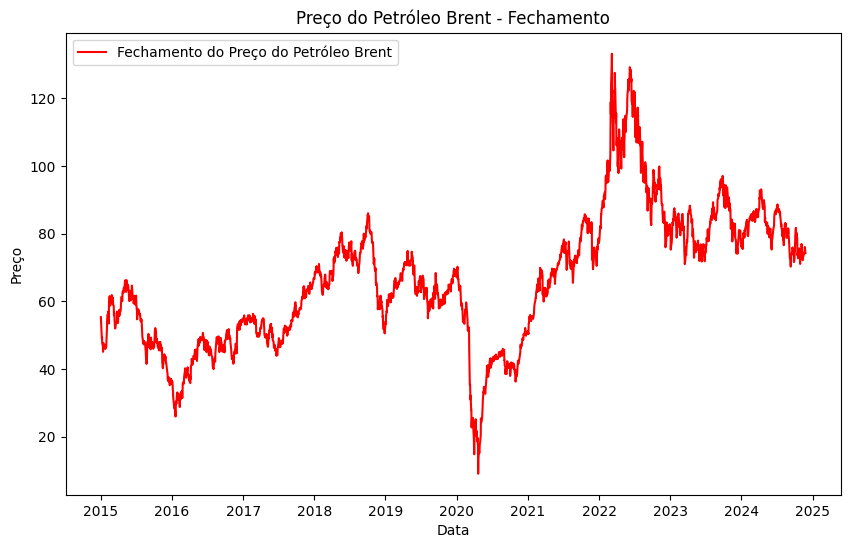

In [31]:
#Plot the ACF and PACF using the 'Price' column
plt.figure(figsize=(10, 6))
plt.plot(df_pet_last_years['preco'], label='Fechamento do Preço do Petróleo Brent', color='red') # Accessing the 'Price' column
plt.title('Preço do Petróleo Brent - Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

-------------
##<font color='green'>**MODELO ESCOLHIDO:** Prophet com Regressoras</font>
----------

###<font color='red'>**BIBLIOTECAS**</font>

In [32]:
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

---
###<font color='red'>**SELECIONANDO O DATAFRAME**</font>

In [33]:
df = df_pet_last_years.copy()

In [34]:
df.reset_index(inplace=True)
df = df.rename(columns={"data": "ds", "preco": "y1"})  # Renomear colunas para Prophet

In [35]:
display(df.head())
display(df.tail())
display(df.info())

,ds,y1
0,2015-01-02,55.38
1,2015-01-05,51.08
2,2015-01-06,50.12
3,2015-01-07,49.06
4,2015-01-08,49.43


,ds,y1
2515,2024-11-19,74.32
2516,2024-11-20,74.33
2517,2024-11-21,75.09
2518,2024-11-22,76.10
2519,2024-11-25,74.27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2520 non-null   datetime64[ns]
 1   y1      2520 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


None

---
###<font color='red'>**CRIAÇÃO DAS FEATURES ADICIONAIS**</font>

---
**Média móvel:** Adicionado uma média móvel de 7 dias (media_movel_7) para capturar tendências locais no preço.

**Desvio padrão móvel:** Adicionei o desvio padrão móvel de 7 dias (desvio_padrao_7) para refletir a volatilidade.

**Preenchimento de valores faltantes:** As operações de rolling (média/desvio padrão) criam valores NaN no início da série, então preenchi esses valores usando o método backfill (bfill), que substitui com o valor subsequente mais próximo.

----

In [36]:
df['media_movel_7'] = df['y1'].rolling(window=7).mean() #Média móvel de 7 dias
df['desvio_padrao_7'] = df['y1'].rolling(window=7).std() #Desvio padrao móvel de 7 dias

# Preencher valores NaN (causados pelo rolling) com valores iniciais da série
df.fillna(method='bfill', inplace=True)

<ipython-input-36-6046d1895735>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [37]:
display(df.tail())
display(df.isna().sum())

,ds,y1,media_movel_7,desvio_padrao_7
2515,2024-11-19,74.32,73.302857,0.831339
2516,2024-11-20,74.33,73.608571,0.742640
2517,2024-11-21,75.09,73.970000,0.762649
2518,2024-11-22,76.10,74.432857,0.939410
2519,2024-11-25,74.27,74.558571,0.828984


,0
ds,0
y1,0
media_movel_7,0
desvio_padrao_7,0


---
###<font color='red'>**CRIANDO AS COLUNAS COM OS VALORES ESCALONADO**</font>

In [38]:
# Inicializar o escalador
scaler = MinMaxScaler()

# Aplicar o escalonamento para y, media_movel_7 e desvio_padrao_7
df[['y', 'media_movel_7_scaled', 'desvio_padrao_7_scaled']] = scaler.fit_transform(
    df[['y1', 'media_movel_7', 'desvio_padrao_7']]
)

In [39]:
df.head()

,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
0,2015-01-02,55.38,49.944286,2.78363,0.372884,0.313295,0.242058
1,2015-01-05,51.08,49.944286,2.78363,0.338223,0.313295,0.242058
2,2015-01-06,50.12,49.944286,2.78363,0.330485,0.313295,0.242058
3,2015-01-07,49.06,49.944286,2.78363,0.321941,0.313295,0.242058
4,2015-01-08,49.43,49.944286,2.78363,0.324923,0.313295,0.242058


In [40]:
df.tail()

,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
2515,2024-11-19,74.32,73.302857,0.831339,0.525552,0.520139,0.060231
2516,2024-11-20,74.33,73.608571,0.742640,0.525633,0.522846,0.051970
2517,2024-11-21,75.09,73.970000,0.762649,0.531759,0.526047,0.053833
2518,2024-11-22,76.10,74.432857,0.939410,0.539900,0.530145,0.070296
2519,2024-11-25,74.27,74.558571,0.828984,0.525149,0.531259,0.060012


In [41]:
df.shape

(2520, 7)

---
###<font color='red'>**DIVISÃO DOS DADOS DE TREINO E TESTE**</font>

In [42]:
#Dividir a quantidade de corte de teste e treino
len_train = int(len(df)*0.8)

#Dividir os dados em treino e teste(90% treino, 10% teste)
train_df = df[:len_train]
test_df = df[len_train:]

print(f'Tamanho do conjunto de treinamento: {len(train_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

Tamanho do conjunto de treinamento: 2016
Tamanho do conjunto de teste: 504


In [43]:
#Exibir os primeiros registros dos conjunts de treino e teste não escalonados
print('Conjunto de treinamento:')
display(train_df.head())
display(train_df.tail())
print(f'Tamanho do conjunto de treinamento: {len(train_df)}\n')

print("Conjunto de teste:")
display(test_df.head())
display(test_df.tail())
print(f'Tamanho do conjunto de teste: {len(test_df)}')

Conjunto de treinamento:


,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
0,2015-01-02,55.38,49.944286,2.78363,0.372884,0.313295,0.242058
1,2015-01-05,51.08,49.944286,2.78363,0.338223,0.313295,0.242058
2,2015-01-06,50.12,49.944286,2.78363,0.330485,0.313295,0.242058
3,2015-01-07,49.06,49.944286,2.78363,0.321941,0.313295,0.242058
4,2015-01-08,49.43,49.944286,2.78363,0.324923,0.313295,0.242058


,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
2011,2022-11-15,94.30,95.468571,2.391739,0.686603,0.716420,0.205559
2012,2022-11-16,92.61,94.431429,1.612022,0.672981,0.707236,0.132940
2013,2022-11-17,91.00,93.595714,1.664731,0.660003,0.699836,0.137849
2014,2022-11-18,88.93,93.007143,2.438379,0.643318,0.694624,0.209903
2015,2022-11-21,88.44,92.177143,2.891538,0.639368,0.687274,0.252108


Tamanho do conjunto de treinamento: 2016

Conjunto de teste:


,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
2016,2022-11-22,88.65,91.074286,2.466866,0.641061,0.677508,0.212556
2017,2022-11-23,85.90,89.975714,2.843383,0.618894,0.667780,0.247623
2018,2022-11-24,85.59,88.731429,2.523433,0.616395,0.656762,0.217825
2019,2022-11-25,83.40,87.415714,2.564806,0.598743,0.645111,0.221678
2020,2022-11-28,83.50,86.344286,2.377652,0.599549,0.635623,0.204247


,ds,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
2515,2024-11-19,74.32,73.302857,0.831339,0.525552,0.520139,0.060231
2516,2024-11-20,74.33,73.608571,0.742640,0.525633,0.522846,0.051970
2517,2024-11-21,75.09,73.970000,0.762649,0.531759,0.526047,0.053833
2518,2024-11-22,76.10,74.432857,0.939410,0.539900,0.530145,0.070296
2519,2024-11-25,74.27,74.558571,0.828984,0.525149,0.531259,0.060012


Tamanho do conjunto de teste: 504


---
###<font color='red'>**TREINANDO O MODELO COM REGRESSORAS**</font>

In [44]:
#Inicializando o modelo
model = Prophet()

#Add regressoras ao modelo
model.add_regressor('media_movel_7')
model.add_regressor('desvio_padrao_7')

#Treinando o modelo nos dados de treino
model.fit(train_df[['ds', 'y', 'media_movel_7', 'desvio_padrao_7']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwqmhekr/pfvr1frf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwqmhekr/joj8ctk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72362', 'data', 'file=/tmp/tmpdwqmhekr/pfvr1frf.json', 'init=/tmp/tmpdwqmhekr/joj8ctk8.json', 'output', 'file=/tmp/tmpdwqmhekr/prophet_modelsec1on90/prophet_model-20241204014322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


---
###<font color='red'>**PREVISÕES**</font>

In [45]:
# Criar DataFrame com as mesmas datas do conjunto de teste
df_future_test = test_df[['ds', 'y', 'media_movel_7', 'desvio_padrao_7']]

In [46]:
df_future_test.head()

,ds,y,media_movel_7,desvio_padrao_7
2016,2022-11-22,0.641061,91.074286,2.466866
2017,2022-11-23,0.618894,89.975714,2.843383
2018,2022-11-24,0.616395,88.731429,2.523433
2019,2022-11-25,0.598743,87.415714,2.564806
2020,2022-11-28,0.599549,86.344286,2.377652


In [47]:
# Fazer previsões
forecast_test = model.predict(df_future_test)

In [48]:
#Setando o index de data para poder relacionar as tabelas entre si
forecast_test.set_index('ds', inplace=True)
test_df.set_index('ds', inplace=True)

In [49]:
display(forecast_test.head())
display(test_df.head())

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,desvio_padrao_7,desvio_padrao_7_lower,desvio_padrao_7_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,media_movel_7,media_movel_7_lower,media_movel_7_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-22,0.422295,0.636967,0.682230,0.422295,0.422295,0.237324,0.237324,0.237324,-0.001724,-0.001724,-0.001724,0.231377,0.231377,0.231377,0.233101,0.233101,0.233101,0.008509,0.008509,0.008509,-0.002562,-0.002562,-0.002562,0.0,0.0,0.0,0.659618
2022-11-23,0.422296,0.628974,0.673841,0.422296,0.422296,0.228511,0.228511,0.228511,-0.002421,-0.002421,-0.002421,0.221876,0.221876,0.221876,0.224297,0.224297,0.224297,0.009101,0.009101,0.009101,-0.002466,-0.002466,-0.002466,0.0,0.0,0.0,0.650807
2022-11-24,0.422298,0.619438,0.665032,0.422298,0.422298,0.219157,0.219157,0.219157,-0.001829,-0.001829,-0.001829,0.212497,0.212497,0.212497,0.214326,0.214326,0.214326,0.009024,0.009024,0.009024,-0.002364,-0.002364,-0.002364,0.0,0.0,0.0,0.641455
2022-11-25,0.422299,0.608899,0.653014,0.422299,0.422299,0.208967,0.208967,0.208967,-0.001905,-0.001905,-0.001905,0.201876,0.201876,0.201876,0.203781,0.203781,0.203781,0.009346,0.009346,0.009346,-0.002255,-0.002255,-0.002255,0.0,0.0,0.0,0.631266
2022-11-28,0.422304,0.597961,0.645140,0.422304,0.422304,0.200429,0.200429,0.200429,-0.001559,-0.001559,-0.001559,0.193636,0.193636,0.193636,0.195195,0.195195,0.195195,0.008674,0.008674,0.008674,-0.001881,-0.001881,-0.001881,0.0,0.0,0.0,0.622732


,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled
ds,,,,,,
2022-11-22,88.65,91.074286,2.466866,0.641061,0.677508,0.212556
2022-11-23,85.90,89.975714,2.843383,0.618894,0.667780,0.247623
2022-11-24,85.59,88.731429,2.523433,0.616395,0.656762,0.217825
2022-11-25,83.40,87.415714,2.564806,0.598743,0.645111,0.221678
2022-11-28,83.50,86.344286,2.377652,0.599549,0.635623,0.204247


In [50]:
# Adicionar previsões ao DataFrame de teste
test_df['yhat_scaled'] = forecast_test['yhat']

<ipython-input-50-dc9aea2e7998>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['yhat_scaled'] = forecast_test['yhat']


In [51]:
test_df.head()

,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled,yhat_scaled
ds,,,,,,,
2022-11-22,88.65,91.074286,2.466866,0.641061,0.677508,0.212556,0.659618
2022-11-23,85.90,89.975714,2.843383,0.618894,0.667780,0.247623,0.650807
2022-11-24,85.59,88.731429,2.523433,0.616395,0.656762,0.217825,0.641455
2022-11-25,83.40,87.415714,2.564806,0.598743,0.645111,0.221678,0.631266
2022-11-28,83.50,86.344286,2.377652,0.599549,0.635623,0.204247,0.622732


---
###<font color='red'>**REVERTENDO O ESCALONAMENTO**</font>

---
O método scaler.inverse_transform espera receber o mesmo número de colunas que foram escalonadas inicialmente. Como escalonamos três colunas (y, media_movel_7, desvio_padrao_7), o inverso também precisa de um array com três colunas para funcionar.

----

In [52]:
#Criar array temporário para reverter apenas a escala de yhat
temp_array = np.zeros((len(test_df), 3))  # Array com 3 colunas (como no escalonamento original)
temp_array[:, 0] = test_df['yhat_scaled']  # Substituir apenas a primeira coluna com os valores de yhat_scaled

In [53]:
#Criar uma nova coluna revertendo a escala de y usando apenas a primeira coluna
test_df['yhat'] = scaler.inverse_transform(temp_array)[:, 0]  # Obter apenas a coluna revertida

<ipython-input-53-38164f3029ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['yhat'] = scaler.inverse_transform(temp_array)[:, 0]  # Obter apenas a coluna revertida


In [54]:
test_df.head()

,y1,media_movel_7,desvio_padrao_7,y,media_movel_7_scaled,desvio_padrao_7_scaled,yhat_scaled,yhat
ds,,,,,,,,
2022-11-22,88.65,91.074286,2.466866,0.641061,0.677508,0.212556,0.659618,90.952256
2022-11-23,85.90,89.975714,2.843383,0.618894,0.667780,0.247623,0.650807,89.859143
2022-11-24,85.59,88.731429,2.523433,0.616395,0.656762,0.217825,0.641455,88.698856
2022-11-25,83.40,87.415714,2.564806,0.598743,0.645111,0.221678,0.631266,87.434815
2022-11-28,83.50,86.344286,2.377652,0.599549,0.635623,0.204247,0.622732,86.376173


---
###<font color='red'>**AVALIANDO O MODELO E EXIBINDO RESULTADOS**</font>



In [55]:
#Importando bibliotecas
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [56]:
#Calculando as métricas de erro
mae = mean_absolute_error(test_df['y1'], test_df['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y1'], test_df['yhat']))
r2 = r2_score(test_df['y1'], test_df['yhat'])

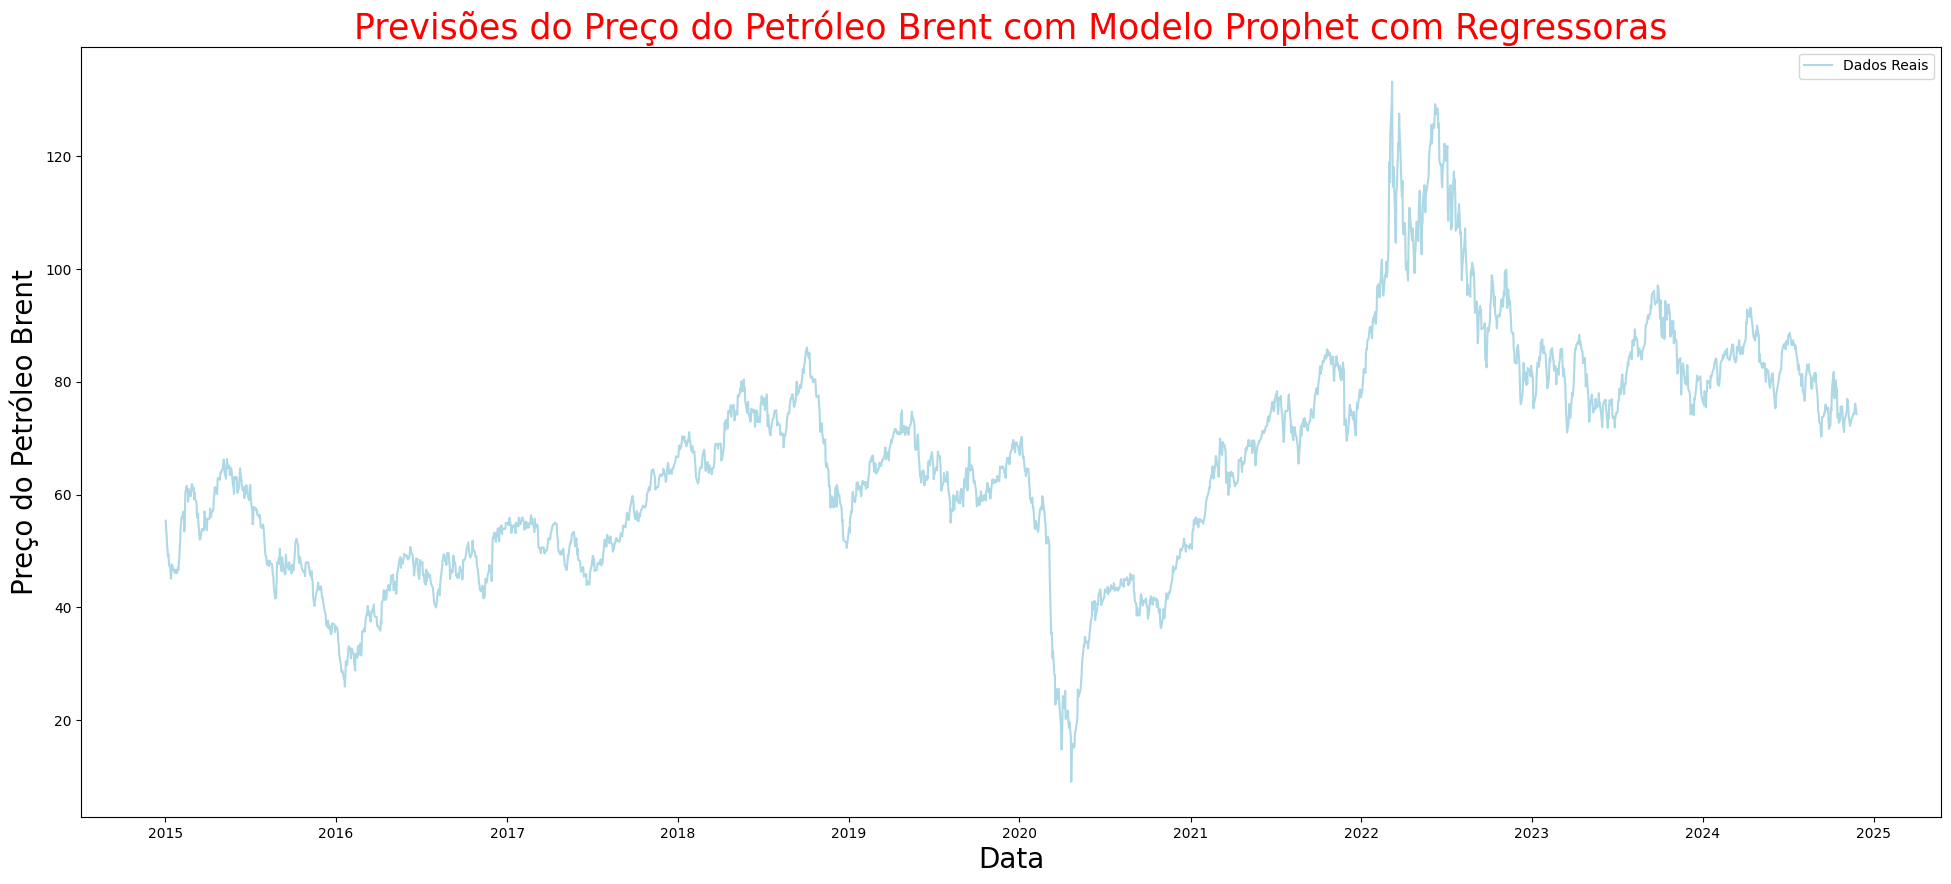

MAE: 1.8184663406517052
RMSE: 2.2579992002634977
R²: 83.95%


In [57]:
plt.figure(figsize=(24, 10))

# Valores reais
plt.plot(df['ds'], df['y1'], label='Dados Reais', color='lightblue')

# Previsões do teste
#plt.plot(test_df['yhat'], label='Dados Previstos', linestyle='--', color='red')

plt.title('Previsões do Preço do Petróleo Brent com Modelo Prophet com Regressoras', color='red', fontsize=25)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Preço do Petróleo Brent', fontsize=20)
plt.legend()
plt.show()

print(f"MAE: {mae}\nRMSE: {rmse}\nR²: {r2:.2%}")